In [1]:
import cv2
import torch
import random
import numpy as np


from pose.utils import project_points
from utils.draw_utils import draw_bbox_3d, draw_axis

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(20231223)
torch.manual_seed(20231223)
torch.cuda.manual_seed(20231223)

num_sample = 300

In [3]:
net = torch.load('./weights/20240505/onepose_plusplus-imgs-relative_r-gt_t-6d-300-2024-05-04-11-45-00-0.3358.pth').to(device)

net.eval()

Mkpts_Reg_Model(
  (embedding): Embedding()
  (transformer_mkpts): Transformer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=76, out_features=76, bias=True)
    )
    (linear1): Linear(in_features=76, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=76, bias=True)
    (norm1): LayerNorm((76,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((76,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (mlp1): Sequential(
    (0): Linear(in_features=22800, out_features=11400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=11400, out_features=2000, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
  )
  (convnextv2): ConvNeXtV2(
    (model): ConvNeXtV2(
      (downsample_laye

In [4]:
prompt = '361'
target = '363'
dataset_path = 'onepose_plusplus/'
path1 = '0702-sheep-others/'
path2 = 'sheep-2/'

In [5]:
# tee 0578-tee-others/tee-2/color/701.png-601.png

In [6]:
prompt_mkpts0_path = 'data/' + dataset_path[:-1] + '-points/' + path1 + 'mkpts0/' + f'{prompt}.png-{target}.png.txt'
target_mkpts1_path = 'data/' + dataset_path[:-1] + '-points/' + path1 + 'mkpts1/' + f'{prompt}.png-{target}.png.txt'

prompt_img0_path = 'data/' + dataset_path[:-1] + '-points/' + path1 + 'img0/' + f'{prompt}.png-{target}.png.png'
prompt_img1_path = 'data/' + dataset_path[:-1] + '-points/' + path1 + 'img1/' + f'{prompt}.png-{target}.png.png'

full_img_path = 'data/' + dataset_path + path1 + path2 + 'color/' + target + '.png'

In [7]:
prompt_mkpts0 = np.loadtxt(prompt_mkpts0_path)
target_mkpts1 = np.loadtxt(target_mkpts1_path)

prompt_img0 = cv2.imread(prompt_img0_path)
target_img1 = cv2.imread(prompt_img1_path)
full_img = cv2.imread(full_img_path)

In [8]:
if len(prompt_mkpts0) > num_sample:
    idx = random.sample(range(len(prompt_mkpts0)), num_sample)
    prompt_mkpts0 = prompt_mkpts0[idx]
    target_mkpts1 = target_mkpts1[idx]
else:
    prompt_mkpts0 = np.concatenate([prompt_mkpts0, np.zeros((num_sample - len(prompt_mkpts0), 2))], axis=0)
    target_mkpts1 = np.concatenate([target_mkpts1, np.zeros((num_sample - len(target_mkpts1), 2))], axis=0)

In [9]:
# 相机内参矩阵
# K0是prompt的相机内参矩阵
K0 = np.loadtxt('data/' + dataset_path + path1 + path2 + 'intrin_ba/' + prompt + '.txt')

# K1是target的相机内参矩阵
K1 = np.loadtxt('data/' + dataset_path + path1 + path2 + 'intrin_ba/' + target + '.txt')

# 这里是Linemod中的第一类物体
# 在lm_models/models/models_info.json中可以找到下面的坐标信息
# lm_models/models/obj_000001.ply是这个模型的点云
_3d_bbox = np.loadtxt('data/' + dataset_path + path1 + 'box3d_corners.txt')

prompt_pose = np.loadtxt('data/' + dataset_path + path1 + path2 + 'poses_ba/' + prompt + '.txt')
target_pose = np.loadtxt('data/' + dataset_path + path1 + path2 + 'poses_ba/' + target + '.txt')

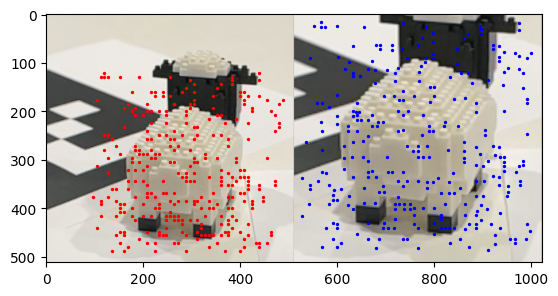

In [10]:
plt.figure()


plt.imshow(cv2.cvtColor(np.concatenate((prompt_img0, target_img1), axis=1), cv2.COLOR_BGR2RGB))
plt.scatter(prompt_mkpts0[:, 0], prompt_mkpts0[:, 1], c='r', s=2)
plt.scatter(target_mkpts1[:, 0] + 512, target_mkpts1[:, 1], c='b', s=2)

plt.show()

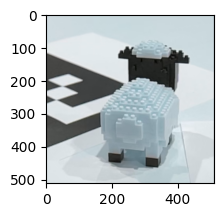

In [11]:
mkpts0_img = np.ones_like((256, 256))

plt.figure()

plt.subplot(211)
plt.imshow(prompt_img0)

In [12]:
mkpts0 = torch.from_numpy(prompt_mkpts0).unsqueeze(0).float().to(device)
mkpts1 = torch.from_numpy(target_mkpts1).unsqueeze(0).float().to(device)

img0 = torch.from_numpy(prompt_img0).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)
img1 = torch.from_numpy(target_img1).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

pre_t, pre_rot = net(mkpts0, mkpts1, img0, img1)
pre_t = pre_t[0].squeeze(0).detach().cpu().numpy()
pre_rot = pre_rot[0].squeeze(0).detach().cpu().numpy()

In [13]:
predict_pose = np.zeros((3, 4)).astype(np.float32)
# 将相对旋转作用到prompt_pose的旋转上
predict_pose[:3, :3] = np.matmul(pre_rot, prompt_pose[:3, :3])
our_predict_pose = predict_pose[:3, :3].copy()
# target_pose中的位移不会改变，直接赋值给predict_pose
predict_pose[:3, 3] = target_pose[:3, 3]
# 将3Dbbox根据predict_pose和target视角下的内参投影到2D平面上
pre_bbox_pts_3d, _ = project_points(_3d_bbox, predict_pose[:3, :4], K1)
pre_bbox_pts_3d = pre_bbox_pts_3d.astype(np.int32)

pre_bbox_pts_3d_gt, _ = project_points(_3d_bbox, target_pose[:3, :4], K1)
pre_bbox_pts_3d_gt = pre_bbox_pts_3d_gt.astype(np.int32)

In [14]:
res_img = full_img.copy()

bbox_img = draw_bbox_3d(res_img, pre_bbox_pts_3d, (255, 255, 255))
bbox_img = draw_axis(bbox_img, predict_pose[:3, :3], predict_pose[:3, 3], K1)
bbox_img = draw_bbox_3d(bbox_img, pre_bbox_pts_3d_gt, (0, 255, 0))
bbox_img = draw_axis(bbox_img, target_pose[:3, :3], target_pose[:3, 3], K1)

2024-05-08 10:33:26.556676


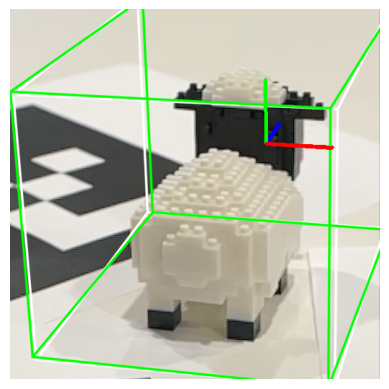

In [15]:
from datetime import datetime
print(datetime.now())

plt.figure()
plt.axis('off')

plt.imshow(cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB))

plt.show()

In [16]:
cv2.imwrite(f'res_img/{prompt}-{target}-onepose_plusplus-ours-imgs.png', bbox_img)

True